# Intro to neural networks

**This notebook is a high-level introduction to solving fairly straightforward machine learning tasks with neural networks. For a more in-depth introduction, see [`Neural_networks_from_scratch.ipynb`](Neural_networks_from_scratch.ipynb).**

We're going to look at the same lithology prediction task we looked at in [`Multiclass_classification.ipynb`](Multiclass_classification.ipynb).

<img src="../images/machine_learning_primer.png"></img>

## Make `X` and `y`

In [2]:
import pandas as pd

df = pd.read_csv('https://geocomp.s3.amazonaws.com/data/Panoma_training_data.csv')
df.head()

,Well Name,Depth,Formation,RelPos,Marine,GR,ILD,DeltaPHI,PHIND,PE,Facies,LATITUDE,LONGITUDE,ILD_log10,Lithology,RHOB,Mineralogy,Siliciclastic
0,SHRIMPLIN,851.3064,A1 SH,1.000,1,77.45,4.613176,9.9,11.915,4.6,3.0,37.978076,-100.987305,0.664,siltstone,2393.499945,siliciclastic,True
1,SHRIMPLIN,851.4588,A1 SH,0.979,1,78.26,4.581419,14.2,12.565,4.1,3.0,37.978076,-100.987305,0.661,siltstone,2416.119814,siliciclastic,True
2,SHRIMPLIN,851.6112,A1 SH,0.957,1,79.05,4.549881,14.8,13.050,3.6,3.0,37.978076,-100.987305,0.658,siltstone,2404.576056,siliciclastic,True
3,SHRIMPLIN,851.7636,A1 SH,0.936,1,86.10,4.518559,13.9,13.115,3.5,3.0,37.978076,-100.987305,0.655,siltstone,2393.249071,siliciclastic,True
4,SHRIMPLIN,851.9160,A1 SH,0.915,1,74.58,4.436086,13.5,13.300,3.4,3.0,37.978076,-100.987305,0.647,siltstone,2382.602601,siliciclastic,True


`X` is going to be the columns `'GR','RHOB','PE','ILD_log10'` and `y` will be the `'Lithology'` column. We'll cast the data to NumPy arrays.

In [3]:
features = ['GR','RHOB','PE','ILD_log10']

# You *can* leave these as Pandas objects, but I prefer NumPy arrays, especially for plotting.
X = df[features].values
y = df['Lithology'].values

## Split

In general, you need three datasets for training and evaulating models:

- **Train** &mdash; For fitting a candidate model.
- **Val** &mdash; For seeing how well a candidate model generalizes. In practice, this is often drawn from the training data using an iterative cross-validation strategy (as opposed to a holdout strategy).
- **Test** &mdash; For seeing how well the final model generalizes.

Be careful; people give these different names sometimes.

Let's see how the labels are distributed against the wells:

In [4]:
pd.crosstab(df['Lithology'], df['Well Name'])

Well Name,CHURCHMAN BIBLE,CRAWFORD,CROSS H CATTLE,LUKE G U,NEWBY,NOLAN,SHANKLE,SHRIMPLIN,STUART
Lithology,,,,,,,,,
dolomite,34,63,2,20,16,4,17,5,29
limestone,125,75,68,74,87,116,40,81,71
mudstone,43,55,53,37,86,75,26,81,87
sandstone,8,15,158,0,0,4,89,0,8
siltstone,106,77,184,246,178,186,205,241,163
wackestone,87,62,31,84,96,30,71,63,104


Now we can make a sensible selection of wells for training and cross-validation:

In [5]:
train_wells = ['CHURCHMAN BIBLE', 'CROSS H CATTLE', 'LUKE G U', 'NEWBY', 'NOLAN', 'SHANKLE', 'SHRIMPLIN']

train_flag = df['Well Name'].isin(train_wells)
X_train = df.loc[train_flag, features].values
y_train = df.loc[train_flag, 'Lithology'].values

# And we might need this later...
wells = df.loc[train_flag, 'Well Name'].values

In [6]:
X_train.shape, y_train.shape

((3157, 4), (3157,))

The the complement go to test:

In [7]:
# Complement: CRAWFORD, STUART
X_test = df.loc[~train_flag, features].values
y_test = df.loc[~train_flag, 'Lithology'].values
X_test.shape, y_test.shape

((809, 4), (809,))

## Check the distributions

Let's visualize the distributions over the features, for each of the datasets. We'd like the distributions to match, i.e. training (and cross-val) matches test.

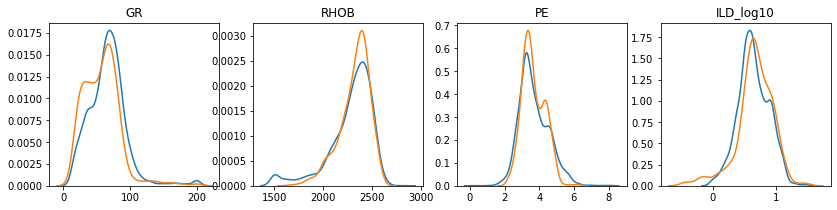

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=4, figsize=(14,3))

for ax, feature, *datasets in zip(axs, features, X_train.T, X_test.T):
    for dataset in datasets:
        sns.kdeplot(dataset, ax=ax)
    ax.set_ylabel(None)
    ax.set_title(feature)

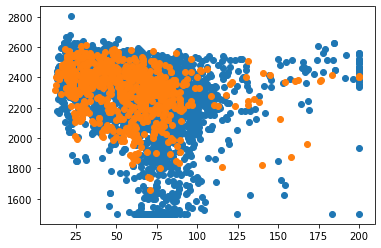

In [9]:
plt.scatter(X_train[:,0], X_train[:,1])
plt.scatter(X_test[:,0], X_test[:,1])

## Scale

Some methods don't care about the scale of the features. For example, decision trees and random forests treat each feature independently.

However, most methods &mdash; for example those relying on distance (e.g. KNN), or on linear combinations (e.g. linear regression), or on squeezing functions (e.g. neural nets) &mdash; require the data to be normalized or standardized:

- **Normalization**: scaling to a range of [0, 1] or [-1, +1] for example. As a rule of thumb, you might do this for uniformly distributed data.
- **Standardization**: scaling to a zero mean and unit variance (also known as Z-score). Do this for normally (Gaussian) distributed data.

It's likely a good idea to scale it no matter which method you try.

`scikit-learn` has lots of scalers. The `StandardScaler` removes the mean and scales the data to unit variance.

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_scaled = scaler.transform(X_train)

**Note that we're not actually going to scale the data at this point. We just want to see what the scaled data will look like.**

Now let's plot the data using equal axes:

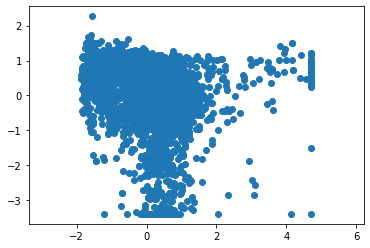

In [11]:
plt.scatter(X_scaled[:,0], X_scaled[:,1])
plt.axis('equal')
plt.show()

### Fit the scaler to `train`

It's imperative to fit the scaler (i.e. for the standardizer, to set the mean and standard deviation) on the **training** data only. It must not 'know' about the mean or range of the data you'll use to evaluate the model. 

### Should you scale the target?

There is usually no advantage to scaling the target, but it can make a difference to neural networks. Very large magnitudes may result in 'exploding gradients', which in turn may result in 'saturation' (for some activation functions), or in very large updates to the parameters. Either way, the network will struggle to learn. So in these cases, we will sometimes scale a regression target for a neural network.

----

We're ready to apply a neural network!

In [12]:
import sklearn

print(sklearn.__version__)

# Make sure we can see all of the model details.
sklearn.set_config(print_changed_only=False)

0.24.2


## Scikit-learn's `MLPClassifier`

A **multi-layer perceptron** is a plain, 'vanilla', feed-forward, artificial neural network.

Scikit-learn is a 'shallow' machine learning, but it does have an MLP implementation. So it's a good place to get used to some of the hyperparameters of deep learning, without having to worry about too much of the code required to train a neural network. 

In [13]:
from sklearn.neural_network import MLPClassifier

MLPClassifier()

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

### EXERCISE

- Build a neural network with 2 hidden layers, with sizes 24 and 24 respectively. Leave the other hyperparameters as their defaults.
- Why do you get a warning? How can you make it go away?
- Which activation function seems to work best out of ReLU, logistic, and tanh?
- What happens if you reduce `learning_rate_init` to 1e-6, or increase it to 1e6? Why?

In [14]:
# YOUR CODE HERE



In [16]:
# Build this up from one example to the loop.
# NB Can't really use early_stopping b/c introduces another split.
# Increase `max_iter` and/or `tol` to make the NN (appear to) converge.
# A lot of the variance is random (different results for different seeds).
# Small lr: learns nothing quickly, large lr: same as DummyClassifier, essentially
import numpy as np
np.set_printoptions(precision=3)

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate 
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline


for act in ['relu', 'logistic', 'tanh']:
    scaler = StandardScaler()
    mlp = MLPClassifier(hidden_layer_sizes=[24, 24],
                        activation=act,
                        max_iter=600,
                        learning_rate_init=1e-3,
                        tol=75e-4,
                        random_state=42
                       )
    model = make_pipeline(scaler, mlp)

    cv_results = cross_validate(model, X_train, y_train,
                                cv=LeaveOneGroupOut(),
                                groups=wells,
                                n_jobs=7)

    print(f'{act:>10s}', s := cv_results['test_score'], f'mean: {np.mean(s):.3f}', f'std: {np.std(s):.3f}')

      relu [0.628 0.556 0.692 0.65  0.687 0.623 0.692] mean: 0.647 std: 0.046
  logistic [0.524 0.431 0.64  0.505 0.631 0.516 0.631] mean: 0.554 std: 0.075
      tanh [0.615 0.536 0.688 0.639 0.639 0.596 0.667] mean: 0.626 std: 0.046


For comparison, here's how a support vector machine does on this dataset:

    array([0.618, 0.45 , 0.711, 0.661, 0.677, 0.629, 0.688])
    
The mean of those scores is 0.633.

We'd often like to see a prediction. Since we're using cross validation, we have to ask `sklearn` to generate this from the cross-val process, taking a prediction when each well in turn is the validation well.

In [17]:
from sklearn.model_selection import cross_val_predict

scaler = StandardScaler()
mlp = MLPClassifier(hidden_layer_sizes=[24, 24],
                    activation=act,
                    max_iter=600,
                    learning_rate_init=1e-3,
                    tol=75e-4,
                    random_state=42
                   )
model = make_pipeline(scaler, mlp)

y_pred = cross_val_predict(model, X_train, y_train,
                                cv=LeaveOneGroupOut(),
                                groups=wells,
                                n_jobs=7)

A lot of the code you'll write for machine learning will be wrangling inputs and outputs. 

To make a nice display here, we will need numbers and colours, not strings. So let's make a transformer to turn the predictions into numbers, and associate a colour with each.

In [18]:
def label_encode(array, classes):
    return np.array(list(map(list(classes).index, array)))

classes = {
    'sandstone': '#F4D03F',
    'siltstone': '#F3E8BF' ,
    'mudstone': '#C1C1C1',
    'wackestone': '#728393',
    'limestone': '#2E86C1',
    'dolomite': '#C186C1'
}

print(label_encode(classes, classes.keys()))

y_train_int = label_encode(y_train, classes.keys())
y_pred_int = label_encode(y_pred, classes.keys())

[0 1 2 3 4 5]


And a pretty ribbon plot to look at the results in a fairly geological way:

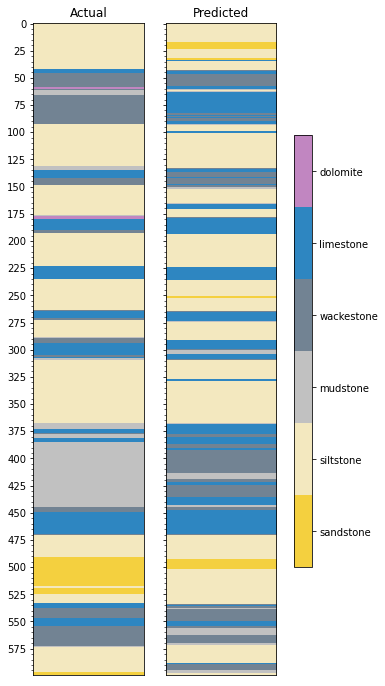

In [19]:
from matplotlib.colors import ListedColormap
import matplotlib.ticker as plticker

fig, axs = plt.subplots(ncols=2, figsize=(5, 12), sharey=True)

cmap_facies = ListedColormap(classes.values(), 'indexed')

ax = axs[0]
im = ax.imshow(y_train_int[:600].reshape(-1, 1), aspect='auto', cmap=cmap_facies, vmin=-0.5, vmax=5.5)
ax.set_title('Actual')
ax.xaxis.set_visible(False)
loc = plticker.MultipleLocator(base=25.0)
ax.yaxis.set_major_locator(loc)
loc = plticker.MultipleLocator(base=5.0)
ax.yaxis.set_minor_locator(loc)

ax = axs[1]
im = ax.imshow(y_pred_int[:600].reshape(-1, 1), aspect='auto', cmap=cmap_facies, vmin=-0.5, vmax=5.5)
ax.set_title('Predicted')
ax.xaxis.set_visible(False)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.05, 0.5])
cbar = fig.colorbar(im, ticks=[0, 1, 2, 3, 4, 5], cax=cbar_ax)
cbar.ax.set_yticklabels(classes.keys())

plt.show()

If you handle a lot of this kind of data, check out [`striplog`](https://code.agilescientific.com/striplog/).

## A PyTorch classifier

`sklearn` is convenient, but it's impossible to do some things in there. For example, there are only 3 activation functions (not including the identity function), and you cannot apply dropout or skip connections. There's also no way to do convolutions or other types of multi-dimensional operation.

On the other hand, you can do anything you like with PyTorch. So let's see how a network might look in there.

In [20]:
import torch
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [73]:
X_train_pt = torch.tensor(X_scaled, dtype=torch.float32).to(device) 
y_train_pt = torch.tensor(y_train_int, dtype=torch.long).to(device)  # Integers.

traindata = torch.utils.data.TensorDataset(X_train_pt, y_train_pt)
trainloader = torch.utils.data.DataLoader(traindata, batch_size=200, shuffle=True)

There's a high-level approach:

In [74]:
net = nn.Sequential(
    nn.Linear(4, 24),
    nn.ReLU(), 
    nn.Linear(24, 6),
    nn.Softmax(dim=-1),
).to(device)

And a low-level approach that gives you fine-tuned control:

In [75]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(4, 24)  # Applies z = Wx + b.
        self.output = nn.Linear(24, 6)
        self.prob = nn.Softmax(dim=-1)

        # Optional.
        nn.init.xavier_uniform_(self.hidden.weight)
        nn.init.zeros_(self.hidden.bias)
        nn.init.xavier_uniform_(self.output.weight)
        nn.init.zeros_(self.output.bias)

    def forward(self, x):
        z1 = self.hidden(x)
        a1 = torch.nn.functional.relu(z1)
        z2 = self.output(a1)
        p2 = self.prob(z2)
        return p2
    
net = Net().to(device)

Training the network:

In [77]:
lr = 0.01
weight_decay = 0.01  # L2 regularization
optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay)

criterion = nn.CrossEntropyLoss()

net.train()

epochs = 500
for epoch in range(1, epochs+1):
    epoch_loss = 0.0
    for xi, yi in trainloader:
        optimizer.zero_grad()
        y_hat = net(xi)
        loss_ = criterion(y_hat, yi)
        loss_.backward()
        optimizer.step()
        epoch_loss += loss_.item()
    if epoch % 50 == 0:
        print(f"# {epoch}  Loss {epoch_loss}")
print('Finished training')

# 50  Loss 23.33532989025116
# 100  Loss 23.2730233669281
# 150  Loss 23.234684944152832
# 200  Loss 23.2191299200058
# 250  Loss 23.19912326335907
# 300  Loss 23.18962264060974
# 350  Loss 23.19525134563446
# 400  Loss 23.17537021636963
# 450  Loss 23.184720396995544
# 500  Loss 23.163820385932922
Finished training


In [82]:
net.eval()

evalloader = torch.utils.data.DataLoader(traindata, shuffle=False)

with torch.no_grad():
    y_pred_torch = np.hstack([np.argmax(net(xi).to('cpu'), axis=-1) for xi, yi in evalloader])
    
y_pred_torch.shape

(3157,)

In [83]:
net(xi).to('cpu')

tensor([[8.3528e-03, 9.1515e-01, 9.6313e-03, 1.1186e-02, 4.8465e-02, 7.2101e-03],
        [7.8267e-03, 8.9469e-03, 2.0567e-02, 4.5080e-01, 5.0424e-01, 7.6255e-03],
        [1.0779e-03, 9.9346e-01, 1.0779e-03, 8.4611e-04, 2.7812e-03, 7.5409e-04],
        [1.6865e-03, 9.9065e-01, 1.9390e-03, 1.5435e-03, 2.8397e-03, 1.3372e-03],
        [6.9659e-03, 9.8643e-03, 2.5534e-02, 8.5221e-01, 9.8691e-02, 6.7325e-03],
        [2.3951e-02, 7.1326e-01, 4.8182e-02, 1.5320e-01, 4.0317e-02, 2.1083e-02],
        [2.4760e-02, 1.2634e-01, 4.1811e-02, 1.9798e-01, 5.8335e-01, 2.5766e-02],
        [1.8874e-02, 4.2544e-02, 3.7827e-02, 2.7681e-01, 6.0325e-01, 2.0693e-02],
        [6.7298e-03, 9.3792e-03, 1.3875e-02, 1.5578e-01, 8.0699e-01, 7.2388e-03],
        [3.1714e-02, 2.1529e-01, 6.7753e-02, 5.2953e-01, 1.2851e-01, 2.7210e-02],
        [6.1078e-03, 7.2338e-03, 1.3340e-02, 1.8178e-01, 7.8507e-01, 6.4653e-03],
        [1.4066e-03, 9.9139e-01, 1.8916e-03, 1.9433e-03, 2.2615e-03, 1.1075e-03],
        [3.6062e

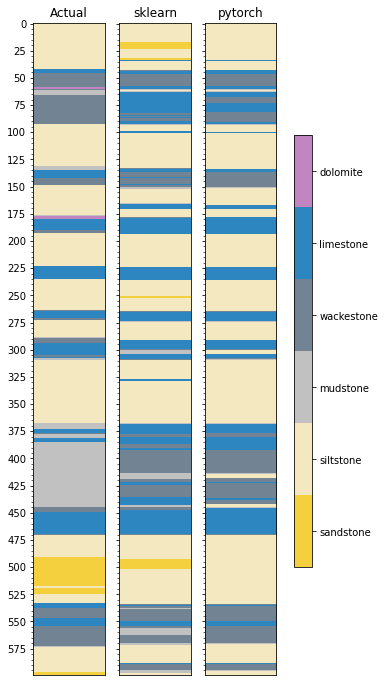

In [86]:
from matplotlib.colors import ListedColormap
import matplotlib.ticker as plticker

fig, axs = plt.subplots(ncols=3, figsize=(5, 12), sharey=True)

cmap_facies = ListedColormap(classes.values(), 'indexed')

ax = axs[0]
im = ax.imshow(y_train_int[:600].reshape(-1, 1), aspect='auto', cmap=cmap_facies, vmin=-0.5, vmax=5.5)
ax.set_title('Actual')
ax.xaxis.set_visible(False)
loc = plticker.MultipleLocator(base=25.0)
ax.yaxis.set_major_locator(loc)
loc = plticker.MultipleLocator(base=5.0)
ax.yaxis.set_minor_locator(loc)

ax = axs[1]
im = ax.imshow(y_pred_int[:600].reshape(-1, 1), aspect='auto', cmap=cmap_facies, vmin=-0.5, vmax=5.5)
ax.set_title('sklearn')
ax.xaxis.set_visible(False)

ax = axs[2]
im = ax.imshow(y_pred_torch[:600].reshape(-1, 1), aspect='auto', cmap=cmap_facies, vmin=-0.5, vmax=5.5)
ax.set_title('pytorch')
ax.xaxis.set_visible(False)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.05, 0.5])
cbar = fig.colorbar(im, ticks=[0, 1, 2, 3, 4, 5], cax=cbar_ax)
cbar.ax.set_yticklabels(classes.keys())

plt.show()

But this result is using the training data directly; really, we'd like to use cross-validation.

That could be fiddly to implement, so let's use `skorch`, a scikit-learn-like interface for PyTorch.

In [92]:
from skorch import NeuralNetClassifier

net = NeuralNetClassifier(Net,
                          max_epochs=200,
                          lr=0.01,
                          iterator_train__shuffle=True,)

pipe = make_pipeline(scaler, net)

cv_scores = cross_validate(pipe, X_train.astype(np.float32), y_train_int, cv=LeaveOneGroupOut(), groups=wells)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7025       0.1488        1.7953  0.0351
      2        1.6047       0.3031        1.7119  0.0284
      3        1.5346       0.4664        1.6483  0.0274
      4        1.4838       0.5009        1.5951  0.0285
      5        1.4426       0.5154        1.5523  0.0271
      6        1.4096       0.5263        1.5161  0.0272
      7        1.3820       0.5372        1.4841  0.0276
      8        1.3577       0.5390        1.4566  0.0282
      9        1.3363       0.5408        1.4320  0.0298
     10        1.3168       0.5463        1.4094  0.0303
     11        1.2990       0.5481        1.3886  0.0301
     12        1.2822       0.5644        1.3694  0.0302
     13        1.2666       0.5681        1.3521  0.0303
     14        1.2518       0.5735        1.3354  0.0301
     15        1.2378       0.5771        1.3200  0.0328
     16        1.2245       0.5

    105        0.9282       0.6243        0.9957  0.0279
    106        0.9274       0.6243        0.9950  0.0279
    107        0.9265       0.6243        0.9934  0.0294
    108        0.9257       0.6261        0.9932  0.0283
    109        0.9249       0.6243        0.9897  0.0285
    110        0.9239       0.6243        0.9878  0.0276
    111        0.9231       0.6243        0.9855  0.0289
    112        0.9224       0.6243        0.9842  0.0273
    113        0.9215       0.6243        0.9830  0.0276
    114        0.9207       0.6261        0.9823  0.0277
    115        0.9199       0.6261        0.9807  0.0278
    116        0.9191       0.6243        0.9799  0.0277
    117        0.9183       0.6279        0.9778  0.0271
    118        0.9175       0.6298        0.9766  0.0281
    119        0.9168       0.6334        0.9760  0.0272
    120        0.9161       0.6334        0.9754  0.0279
    121        0.9153       0.6352        0.9735  0.0273
    122        0.9146       0.6

     11        1.3279       0.6116        1.3150  0.0268
     12        1.3045       0.6173        1.2907  0.0261
     13        1.2831       0.6210        1.2688  0.0264
     14        1.2635       0.6285        1.2491  0.0264
     15        1.2456       0.6304        1.2315  0.0257
     16        1.2292       0.6341        1.2154  0.0265
     17        1.2140       0.6379        1.2007  0.0263
     18        1.2000       0.6417        1.1874  0.0258
     19        1.1871       0.6454        1.1754  0.0262
     20        1.1750       0.6398        1.1647  0.0258
     21        1.1637       0.6454        1.1549  0.0265
     22        1.1533       0.6492        1.1457  0.0259
     23        1.1436       0.6510        1.1375  0.0264
     24        1.1345       0.6548        1.1298  0.0263
     25        1.1259       0.6548        1.1227  0.0260
     26        1.1179       0.6567        1.1162  0.0265
     27        1.1103       0.6567        1.1101  0.0261
     28        1.1033       0.6

    119        0.9282       0.6510        0.9436  0.0271
    120        0.9275       0.6510        0.9429  0.0267
    121        0.9267       0.6510        0.9422  0.0264
    122        0.9259       0.6510        0.9415  0.0264
    123        0.9252       0.6529        0.9402  0.0262
    124        0.9245       0.6529        0.9393  0.0267
    125        0.9239       0.6529        0.9381  0.0263
    126        0.9231       0.6548        0.9375  0.0270
    127        0.9224       0.6548        0.9367  0.0266
    128        0.9217       0.6548        0.9358  0.0258
    129        0.9210       0.6548        0.9348  0.0270
    130        0.9204       0.6548        0.9344  0.0257
    131        0.9196       0.6529        0.9335  0.0266
    132        0.9190       0.6548        0.9328  0.0255
    133        0.9183       0.6529        0.9316  0.0266
    134        0.9176       0.6548        0.9308  0.0319
    135        0.9170       0.6548        0.9301  0.0346
    136        0.9163       0.6

     25        1.1771       0.6019        1.1972  0.0264
     26        1.1684       0.6019        1.1909  0.0265
     27        1.1601       0.6019        1.1849  0.0273
     28        1.1522       0.6037        1.1793  0.0261
     29        1.1446       0.6019        1.1740  0.0261
     30        1.1374       0.6037        1.1691  0.0276
     31        1.1305       0.6074        1.1644  0.0264
     32        1.1239       0.6074        1.1599  0.0265
     33        1.1174       0.6093        1.1556  0.0261
     34        1.1113       0.6093        1.1515  0.0263
     35        1.1055       0.6074        1.1476  0.0266
     36        1.0999       0.6074        1.1439  0.0274
     37        1.0945       0.6074        1.1403  0.0288
     38        1.0892       0.6056        1.1370  0.0274
     39        1.0842       0.6056        1.1337  0.0284
     40        1.0794       0.6056        1.1305  0.0284
     41        1.0747       0.6037        1.1275  0.0259
     42        1.0702       0.6

    133        0.9278       0.6185        1.0170  0.0268
    134        0.9271       0.6222        1.0162  0.0268
    135        0.9265       0.6222        1.0152  0.0265
    136        0.9258       0.6222        1.0141  0.0277
    137        0.9251       0.6222        1.0136  0.0277
    138        0.9246       0.6222        1.0127  0.0269
    139        0.9240       0.6222        1.0118  0.0277
    140        0.9234       0.6222        1.0110  0.0273
    141        0.9228       0.6222        1.0102  0.0267
    142        0.9223       0.6222        1.0094  0.0268
    143        0.9216       0.6241        1.0086  0.0263
    144        0.9210       0.6241        1.0077  0.0270
    145        0.9204       0.6241        1.0072  0.0258
    146        0.9198       0.6222        1.0062  0.0266
    147        0.9193       0.6241        1.0056  0.0260
    148        0.9188       0.6241        1.0050  0.0268
    149        0.9182       0.6222        1.0042  0.0262
    150        0.9176       0.6

     39        1.0551       0.6067        1.1158  0.0258
     40        1.0501       0.6048        1.1115  0.0265
     41        1.0453       0.6067        1.1072  0.0268
     42        1.0407       0.6048        1.1030  0.0265
     43        1.0363       0.6048        1.0990  0.0265
     44        1.0321       0.6048        1.0952  0.0260
     45        1.0281       0.6085        1.0916  0.0274
     46        1.0243       0.6067        1.0882  0.0267
     47        1.0207       0.6085        1.0848  0.0268
     48        1.0173       0.6104        1.0817  0.0269
     49        1.0140       0.6104        1.0785  0.0266
     50        1.0108       0.6085        1.0754  0.0268
     51        1.0078       0.6085        1.0726  0.0269
     52        1.0050       0.6085        1.0699  0.0262
     53        1.0023       0.6085        1.0673  0.0269
     54        0.9996       0.6085        1.0645  0.0265
     55        0.9971       0.6104        1.0621  0.0270
     56        0.9947       0.6

    148        0.9077       0.6197        0.9663  0.0276
    149        0.9071       0.6197        0.9655  0.0273
    150        0.9066       0.6197        0.9647  0.0395
    151        0.9061       0.6215        0.9640  0.0273
    152        0.9056       0.6215        0.9636  0.0268
    153        0.9050       0.6215        0.9632  0.0274
    154        0.9046       0.6215        0.9625  0.0273
    155        0.9041       0.6215        0.9618  0.0267
    156        0.9036       0.6215        0.9612  0.0441
    157        0.9031       0.6215        0.9605  0.0371
    158        0.9025       0.6197        0.9598  0.0310
    159        0.9021       0.6197        0.9591  0.0303
    160        0.9016       0.6197        0.9583  0.0304
    161        0.9011       0.6197        0.9578  0.0281
    162        0.9006       0.6215        0.9572  0.0307
    163        0.9001       0.6215        0.9567  0.0284
    164        0.8997       0.6234        0.9560  0.0277
    165        0.8992       0.6

     51        1.0483       0.5974        1.1641  0.0279
     52        1.0450       0.5938        1.1600  0.0275
     53        1.0419       0.5938        1.1566  0.0279
     54        1.0389       0.5938        1.1529  0.0275
     55        1.0359       0.5938        1.1497  0.0275
     56        1.0331       0.5974        1.1476  0.0277
     57        1.0305       0.5993        1.1444  0.0283
     58        1.0278       0.6029        1.1423  0.0283
     59        1.0252       0.6029        1.1415  0.0275
     60        1.0228       0.6011        1.1388  0.0286
     61        1.0204       0.6011        1.1364  0.0281
     62        1.0180       0.6011        1.1349  0.0270
     63        1.0157       0.6011        1.1346  0.0269
     64        1.0136       0.6011        1.1323  0.0271
     65        1.0114       0.6011        1.1303  0.0270
     66        1.0093       0.5993        1.1284  0.0268
     67        1.0074       0.5993        1.1254  0.0272
     68        1.0054       0.6

    162        0.9170       0.6120        1.0144  0.0278
    163        0.9166       0.6120        1.0125  0.0281
    164        0.9160       0.6138        1.0120  0.0269
    165        0.9155       0.6138        1.0111  0.0278
    166        0.9151       0.6138        1.0140  0.0278
    167        0.9146       0.6138        1.0124  0.0270
    168        0.9140       0.6157        1.0125  0.0277
    169        0.9136       0.6157        1.0106  0.0279
    170        0.9131       0.6120        1.0114  0.0271
    171        0.9126       0.6120        1.0110  0.0284
    172        0.9122       0.6102        1.0108  0.0271
    173        0.9117       0.6138        1.0087  0.0281
    174        0.9113       0.6102        1.0082  0.0282
    175        0.9108       0.6120        1.0070  0.0272
    176        0.9103       0.6102        1.0076  0.0282
    177        0.9099       0.6102        1.0059  0.0280
    178        0.9095       0.6138        1.0054  0.0268
    179        0.9090       0.6

     70        1.0336       0.6144        1.0240  0.0266
     71        1.0322       0.6144        1.0227  0.0272
     72        1.0307       0.6144        1.0214  0.0276
     73        1.0292       0.6162        1.0201  0.0263
     74        1.0278       0.6162        1.0188  0.0271
     75        1.0264       0.6162        1.0176  0.0264
     76        1.0250       0.6144        1.0163  0.0264
     77        1.0237       0.6144        1.0151  0.0275
     78        1.0223       0.6144        1.0138  0.0261
     79        1.0210       0.6144        1.0125  0.0280
     80        1.0198       0.6144        1.0111  0.0263
     81        1.0184       0.6144        1.0099  0.0274
     82        1.0172       0.6144        1.0088  0.0383
     83        1.0159       0.6125        1.0076  0.0282
     84        1.0147       0.6125        1.0065  0.0283
     85        1.0135       0.6125        1.0053  0.0331
     86        1.0123       0.6125        1.0042  0.0372
     87        1.0110       0.6

    178        0.9469       0.6531        0.9324  0.0265
    179        0.9466       0.6513        0.9319  0.0273
    180        0.9462       0.6513        0.9313  0.0271
    181        0.9458       0.6513        0.9308  0.0269
    182        0.9454       0.6531        0.9305  0.0274
    183        0.9450       0.6531        0.9299  0.0266
    184        0.9447       0.6531        0.9294  0.0273
    185        0.9443       0.6531        0.9289  0.0268
    186        0.9440       0.6550        0.9283  0.0260
    187        0.9436       0.6550        0.9279  0.0268
    188        0.9433       0.6550        0.9274  0.0261
    189        0.9429       0.6550        0.9270  0.0266
    190        0.9426       0.6550        0.9263  0.0261
    191        0.9422       0.6550        0.9258  0.0264
    192        0.9418       0.6550        0.9253  0.0263
    193        0.9415       0.6550        0.9248  0.0263
    194        0.9412       0.6550        0.9244  0.0265
    195        0.9408       0.6

     81        1.0063       0.6431        1.0189  0.0259
     82        1.0049       0.6431        1.0174  0.0271
     83        1.0035       0.6431        1.0160  0.0264
     84        1.0021       0.6431        1.0147  0.0271
     85        1.0008       0.6431        1.0134  0.0268
     86        0.9995       0.6413        1.0122  0.0262
     87        0.9982       0.6394        1.0108  0.0270
     88        0.9968       0.6394        1.0095  0.0259
     89        0.9956       0.6394        1.0084  0.0272
     90        0.9943       0.6394        1.0072  0.0259
     91        0.9932       0.6375        1.0060  0.0274
     92        0.9919       0.6375        1.0048  0.0262
     93        0.9907       0.6357        1.0037  0.0264
     94        0.9896       0.6357        1.0026  0.0264
     95        0.9884       0.6357        1.0013  0.0259
     96        0.9872       0.6357        1.0001  0.0261
     97        0.9861       0.6357        0.9990  0.0260
     98        0.9850       0.6

    191        0.9202       0.6208        0.9315  0.0270
    192        0.9198       0.6208        0.9310  0.0269
    193        0.9194       0.6208        0.9305  0.0276
    194        0.9189       0.6208        0.9300  0.0272
    195        0.9185       0.6208        0.9295  0.0266
    196        0.9180       0.6208        0.9290  0.0273
    197        0.9176       0.6208        0.9285  0.0271
    198        0.9173       0.6208        0.9279  0.0273
    199        0.9169       0.6208        0.9274  0.0280
    200        0.9164       0.6208        0.9269  0.0278


{'fit_time': array([6.001, 5.688, 5.733, 5.797, 5.92 , 5.734, 5.673]),
 'score_time': array([0.005, 0.006, 0.007, 0.005, 0.005, 0.006, 0.006]),
 'test_score': array([0.608, 0.464, 0.707, 0.637, 0.677, 0.616, 0.694])}

In [95]:
s = cv_scores['test_score']
s, np.mean(s)

(array([0.608, 0.464, 0.707, 0.637, 0.677, 0.616, 0.694]), 0.6290578402553066)

In [96]:
y_pred_torch = cross_val_predict(pipe,
                                 X_train.astype(np.float32),
                                 y_train_int,
                                 cv=LeaveOneGroupOut(), groups=wells
                                )

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9238       0.1089        1.9219  0.0275
      2        1.8066       0.3140        1.8280  0.0289
      3        1.7116       0.4537        1.7492  0.0290
      4        1.6331       0.5009        1.6807  0.0278
      5        1.5668       0.5299        1.6218  0.0290
      6        1.5118       0.5463        1.5706  0.0295
      7        1.4649       0.5644        1.5261  0.0287
      8        1.4248       0.5771        1.4870  0.0279
      9        1.3901       0.5826        1.4518  0.0272
     10        1.3588       0.5844        1.4208  0.0292
     11        1.3313       0.5844        1.3927  0.0290
     12        1.3070       0.5898        1.3676  0.0295
     13        1.2855       0.5917        1.3449  0.0285
     14        1.2659       0.5971        1.3241  0.0282
     15        1.2482       0.6007        1.3051  0.0286
     16        1.2320       0.6

    106        0.9103       0.6443        0.9174  0.0274
    107        0.9094       0.6443        0.9160  0.0273
    108        0.9085       0.6443        0.9156  0.0284
    109        0.9076       0.6461        0.9143  0.0272
    110        0.9067       0.6443        0.9129  0.0279
    111        0.9059       0.6461        0.9120  0.0268
    112        0.9050       0.6461        0.9108  0.0272
    113        0.9041       0.6479        0.9090  0.0274
    114        0.9033       0.6461        0.9083  0.0272
    115        0.9024       0.6461        0.9066  0.0278
    116        0.9016       0.6479        0.9058  0.0272
    117        0.9008       0.6515        0.9050  0.0277
    118        0.8999       0.6515        0.9036  0.0267
    119        0.8991       0.6515        0.9029  0.0277
    120        0.8984       0.6534        0.9019  0.0271
    121        0.8976       0.6534        0.9012  0.0268
    122        0.8968       0.6534        0.9002  0.0276
    123        0.8960       0.6

     13        1.2451       0.6679        1.2649  0.0271
     14        1.2272       0.6660        1.2483  0.0266
     15        1.2112       0.6679        1.2333  0.0266
     16        1.1966       0.6642        1.2199  0.0265
     17        1.1834       0.6679        1.2077  0.0263
     18        1.1714       0.6679        1.1966  0.0261
     19        1.1604       0.6660        1.1864  0.0265
     20        1.1502       0.6679        1.1770  0.0266
     21        1.1408       0.6660        1.1685  0.0269
     22        1.1323       0.6679        1.1606  0.0263
     23        1.1244       0.6660        1.1532  0.0263
     24        1.1170       0.6642        1.1465  0.0266
     25        1.1101       0.6660        1.1402  0.0267
     26        1.1037       0.6698        1.1341  0.0274
     27        1.0976       0.6717        1.1286  0.0282
     28        1.0920       0.6717        1.1235  0.0271
     29        1.0867       0.6717        1.1185  0.0261
     30        1.0817       0.6

    122        0.9458       0.6811        0.9475  0.0272
    123        0.9452       0.6811        0.9466  0.0293
    124        0.9445       0.6811        0.9454  0.0269
    125        0.9439       0.6811        0.9447  0.0263
    126        0.9432       0.6811        0.9438  0.0259
    127        0.9426       0.6811        0.9430  0.0265
    128        0.9420       0.6811        0.9422  0.0259
    129        0.9413       0.6811        0.9412  0.0259
    130        0.9408       0.6792        0.9400  0.0266
    131        0.9402       0.6811        0.9392  0.0263
    132        0.9395       0.6811        0.9382  0.0279
    133        0.9389       0.6792        0.9372  0.0273
    134        0.9384       0.6792        0.9363  0.0269
    135        0.9377       0.6792        0.9356  0.0272
    136        0.9372       0.6811        0.9348  0.0268
    137        0.9366       0.6773        0.9340  0.0259
    138        0.9360       0.6773        0.9331  0.0259
    139        0.9354       0.6

     28        1.1843       0.5463        1.2415  0.0266
     29        1.1752       0.5444        1.2331  0.0272
     30        1.1664       0.5444        1.2253  0.0266
     31        1.1580       0.5444        1.2180  0.0265
     32        1.1501       0.5407        1.2111  0.0278
     33        1.1425       0.5426        1.2047  0.0266
     34        1.1354       0.5407        1.1987  0.0261
     35        1.1285       0.5444        1.1929  0.0272
     36        1.1220       0.5500        1.1876  0.0267
     37        1.1158       0.5500        1.1825  0.0262
     38        1.1098       0.5537        1.1777  0.0261
     39        1.1041       0.5519        1.1731  0.0263
     40        1.0987       0.5537        1.1690  0.0266
     41        1.0935       0.5593        1.1650  0.0270
     42        1.0886       0.5630        1.1612  0.0265
     43        1.0840       0.5630        1.1575  0.0263
     44        1.0795       0.5630        1.1540  0.0262
     45        1.0752       0.5

    136        0.9457       0.5889        1.0483  0.0268
    137        0.9452       0.5889        1.0478  0.0278
    138        0.9446       0.5889        1.0472  0.0277
    139        0.9441       0.5889        1.0467  0.0268
    140        0.9435       0.5889        1.0460  0.0277
    141        0.9429       0.5889        1.0455  0.0272
    142        0.9424       0.5889        1.0448  0.0271
    143        0.9418       0.5889        1.0444  0.0271
    144        0.9412       0.5889        1.0439  0.0278
    145        0.9407       0.5889        1.0433  0.0286
    146        0.9402       0.5889        1.0428  0.0273
    147        0.9397       0.5889        1.0422  0.0264
    148        0.9391       0.5889        1.0416  0.0280
    149        0.9386       0.5889        1.0410  0.0279
    150        0.9381       0.5889        1.0407  0.0269
    151        0.9376       0.5889        1.0400  0.0274
    152        0.9371       0.5889        1.0394  0.0267
    153        0.9366       0.5

     43        1.0385       0.6048        1.0736  0.0281
     44        1.0347       0.6048        1.0710  0.0282
     45        1.0311       0.6048        1.0686  0.0265
     46        1.0275       0.6030        1.0663  0.0265
     47        1.0241       0.6030        1.0641  0.0270
     48        1.0208       0.6030        1.0619  0.0267
     49        1.0177       0.6030        1.0598  0.0260
     50        1.0146       0.6030        1.0578  0.0266
     51        1.0118       0.6011        1.0561  0.0267
     52        1.0090       0.6011        1.0542  0.0265
     53        1.0063       0.6011        1.0525  0.0268
     54        1.0036       0.6011        1.0507  0.0267
     55        1.0011       0.6011        1.0489  0.0259
     56        0.9986       0.6011        1.0474  0.0267
     57        0.9963       0.6011        1.0458  0.0266
     58        0.9940       0.5993        1.0445  0.0258
     59        0.9918       0.5993        1.0430  0.0268
     60        0.9896       0.5

    153        0.9030       0.6215        0.9747  0.0264
    154        0.9026       0.6215        0.9738  0.0269
    155        0.9021       0.6215        0.9733  0.0267
    156        0.9017       0.6215        0.9729  0.0270
    157        0.9012       0.6234        0.9722  0.0273
    158        0.9008       0.6234        0.9717  0.0265
    159        0.9003       0.6234        0.9711  0.0269
    160        0.8998       0.6234        0.9705  0.0259
    161        0.8993       0.6234        0.9698  0.0263
    162        0.8989       0.6234        0.9693  0.0266
    163        0.8985       0.6234        0.9686  0.0266
    164        0.8980       0.6234        0.9680  0.0267
    165        0.8976       0.6234        0.9675  0.0266
    166        0.8972       0.6234        0.9667  0.0263
    167        0.8967       0.6252        0.9661  0.0270
    168        0.8963       0.6252        0.9655  0.0265
    169        0.8958       0.6252        0.9649  0.0269
    170        0.8955       0.6

     59        1.0221       0.6193        1.1153  0.0268
     60        1.0203       0.6193        1.1153  0.0267
     61        1.0185       0.6175        1.1142  0.0272
     62        1.0168       0.6138        1.1136  0.0271
     63        1.0149       0.6138        1.1112  0.0271
     64        1.0132       0.6138        1.1100  0.0268
     65        1.0117       0.6138        1.1091  0.0297
     66        1.0100       0.6138        1.1086  0.0279
     67        1.0084       0.6138        1.1074  0.0272
     68        1.0069       0.6138        1.1068  0.0269
     69        1.0054       0.6138        1.1050  0.0276
     70        1.0039       0.6157        1.1051  0.0268
     71        1.0025       0.6138        1.1033  0.0265
     72        1.0012       0.6138        1.1023  0.0272
     73        0.9997       0.6120        1.1019  0.0269
     74        0.9984       0.6120        1.1007  0.0273
     75        0.9971       0.6120        1.0987  0.0269
     76        0.9958       0.6

    171        0.9205       0.6102        1.0267  0.0279
    172        0.9200       0.6120        1.0266  0.0267
    173        0.9195       0.6120        1.0264  0.0269
    174        0.9189       0.6157        1.0250  0.0282
    175        0.9185       0.6138        1.0232  0.0281
    176        0.9180       0.6120        1.0222  0.0270
    177        0.9174       0.6175        1.0210  0.0284
    178        0.9170       0.6138        1.0208  0.0273
    179        0.9165       0.6157        1.0205  0.0282
    180        0.9160       0.6157        1.0219  0.0288
    181        0.9155       0.6157        1.0217  0.0329
    182        0.9151       0.6175        1.0206  0.0297
    183        0.9145       0.6175        1.0213  0.0282
    184        0.9141       0.6175        1.0194  0.0268
    185        0.9136       0.6193        1.0194  0.0266
    186        0.9132       0.6138        1.0184  0.0268
    187        0.9128       0.6120        1.0160  0.0273
    188        0.9124       0.6

     77        1.0107       0.6144        1.0267  0.0271
     78        1.0095       0.6162        1.0250  0.0268
     79        1.0083       0.6162        1.0234  0.0282
     80        1.0071       0.6144        1.0218  0.0274
     81        1.0059       0.6181        1.0202  0.0272
     82        1.0048       0.6236        1.0186  0.0271
     83        1.0036       0.6255        1.0171  0.0269
     84        1.0025       0.6292        1.0157  0.0287
     85        1.0015       0.6328        1.0142  0.0277
     86        1.0004       0.6328        1.0127  0.0266
     87        0.9994       0.6347        1.0112  0.0275
     88        0.9984       0.6347        1.0099  0.0281
     89        0.9974       0.6347        1.0085  0.0282
     90        0.9964       0.6347        1.0071  0.0283
     91        0.9954       0.6347        1.0058  0.0276
     92        0.9945       0.6347        1.0046  0.0271
     93        0.9935       0.6365        1.0032  0.0267
     94        0.9927       0.6

    185        0.9418       0.6642        0.9228  0.0290
    186        0.9414       0.6642        0.9221  0.0307
    187        0.9410       0.6642        0.9214  0.0288
    188        0.9407       0.6642        0.9207  0.0266
    189        0.9403       0.6642        0.9201  0.0291
    190        0.9399       0.6642        0.9195  0.0331
    191        0.9395       0.6642        0.9190  0.0268
    192        0.9392       0.6642        0.9184  0.0283
    193        0.9389       0.6642        0.9177  0.0271
    194        0.9385       0.6661        0.9171  0.0264
    195        0.9382       0.6661        0.9166  0.0274
    196        0.9378       0.6661        0.9159  0.0275
    197        0.9374       0.6661        0.9154  0.0285
    198        0.9371       0.6661        0.9149  0.0263
    199        0.9368       0.6661        0.9143  0.0268
    200        0.9365       0.6661        0.9137  0.0273
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  --------

     90        0.9780       0.6320        0.9846  0.0279
     91        0.9770       0.6320        0.9836  0.0345
     92        0.9761       0.6320        0.9827  0.0291
     93        0.9752       0.6338        0.9819  0.0292
     94        0.9742       0.6338        0.9809  0.0288
     95        0.9733       0.6320        0.9799  0.0271
     96        0.9724       0.6338        0.9790  0.0272
     97        0.9716       0.6320        0.9780  0.0318
     98        0.9707       0.6357        0.9773  0.0299
     99        0.9699       0.6357        0.9764  0.0299
    100        0.9690       0.6357        0.9755  0.0297
    101        0.9682       0.6338        0.9748  0.0293
    102        0.9673       0.6338        0.9740  0.0291
    103        0.9665       0.6338        0.9732  0.0265
    104        0.9657       0.6338        0.9725  0.0307
    105        0.9650       0.6338        0.9716  0.0324
    106        0.9642       0.6357        0.9709  0.0292
    107        0.9634       0.6

    199        0.9165       0.6264        0.9166  0.0326
    200        0.9162       0.6264        0.9163  0.0277


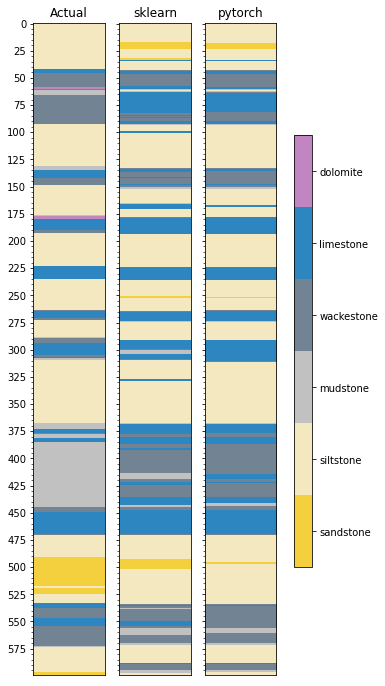

In [99]:
fig, axs = plt.subplots(ncols=3, figsize=(5, 12), sharey=True)

cmap_facies = ListedColormap(classes.values(), 'indexed')

ax = axs[0]
im = ax.imshow(y_train_int[:600].reshape(-1, 1), aspect='auto', cmap=cmap_facies, vmin=-0.5, vmax=5.5)
ax.set_title('Actual')
ax.xaxis.set_visible(False)
loc = plticker.MultipleLocator(base=25.0)
ax.yaxis.set_major_locator(loc)
loc = plticker.MultipleLocator(base=5.0)
ax.yaxis.set_minor_locator(loc)

ax = axs[1]
im = ax.imshow(y_pred_int[:600].reshape(-1, 1), aspect='auto', cmap=cmap_facies, vmin=-0.5, vmax=5.5)
ax.set_title('sklearn')
ax.xaxis.set_visible(False)

ax = axs[2]
im = ax.imshow(y_pred_torch[:600].reshape(-1, 1), aspect='auto', cmap=cmap_facies, vmin=-0.5, vmax=5.5)
ax.set_title('pytorch')
ax.xaxis.set_visible(False)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.05, 0.5])
cbar = fig.colorbar(im, ticks=[0, 1, 2, 3, 4, 5], cax=cbar_ax)
cbar.ax.set_yticklabels(classes.keys())

plt.show()